In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
from framework.base import Dataset
from framework.io import Reader, Writer
from framework.objectivefunction import L1, TSV, TV, Chi2, OFunction
from framework.optimization import ADMM, FISTA, SDMM, GradientBasedMethod
from framework.reconstruction import Parameter
from framework.simulation import FaradayThickSource, FaradayThinSource
from framework.transformers import DFT1D, NUFFT1D, Gridding
from framework.utils import Gaussian, complex_to_real, find_pixel, real_to_complex
from IPython.display import clear_output
from pynufft import NUFFT
from scipy import signal as sci_signal
from scipy.constants import c

In [2]:
np.random.seed(666)

In [3]:
nu = np.linspace(start=1.008e9, stop=2.031e9, num=1000)

In [4]:
peak_thinsource = 0.0035
peak_thicksource = 0.0035

In [5]:
thinsource = FaradayThinSource(nu=nu, s_nu=peak_thinsource, phi_gal=-200, spectral_idx=1.0)

In [6]:
thicksource = FaradayThickSource(
    nu=nu, s_nu=peak_thicksource, phi_fg=140, phi_center=200, spectral_idx=1.0
)

In [7]:
thinsource.simulate()
thicksource.simulate()

In [8]:
simsource = thinsource + thicksource

In [9]:
simsource.spectral_idx

1.0

In [10]:
#simsource.remove_channels(0.4)

In [11]:
#simsource.apply_noise(peak_thinsource/10)

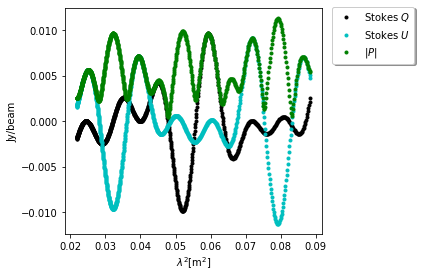

In [12]:
plt.plot(simsource.lambda2, simsource.data.real, 'k.', label=r"Stokes $Q$")
plt.plot(simsource.lambda2, simsource.data.imag, 'c.', label=r"Stokes $U$")
plt.plot(simsource.lambda2, np.abs(simsource.data), 'g.', label=r"$|P|$")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Jy/beam')
plt.legend(loc=(1.04, 0.755), fancybox=True, shadow=True)
plt.tight_layout()
#plt.ylim([-0.01,0.01])
plt.savefig("pol_sim3.png", dpi=100)

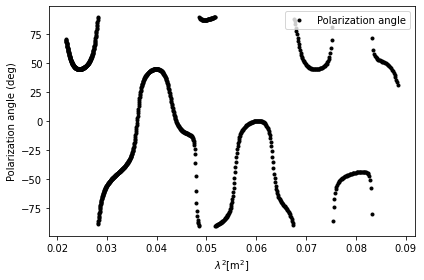

In [13]:
import astropy.units as u

plt.plot(
    simsource.lambda2,
    simsource.calculate_polangle('data').to(u.deg),
    'k.',
    label=r"Polarization angle"
)
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Polarization angle (deg)')
plt.legend(loc='upper right')
plt.tight_layout()

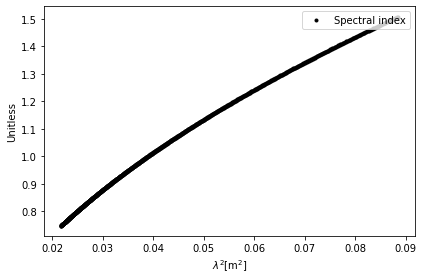

In [14]:
plt.plot(simsource.lambda2, simsource.s, 'k.', label=r"Spectral index")
plt.xlabel(r'$\lambda^2$[m$^{2}$]')
plt.ylabel(r'Unitless')
plt.legend(loc='upper right')
plt.tight_layout()

In [15]:
dataset = simsource

In [16]:
parameter = Parameter()

In [17]:
parameter.calculate_cellsize(dataset=dataset)

FWHM of the main peak of the RMTF: 51.962 rad/m^2
Maximum recovered width structure: 144.188 rad/m^2
Maximum Faraday Depth to which one has more than 50% sensitivity: 25954.896


In [18]:
nufft = NUFFT1D(dataset=dataset, parameter=parameter, solve=True)

In [19]:
dft = DFT1D(dataset=dataset, parameter=parameter)

In [20]:
F_dirty = dft.backward(dataset.data)

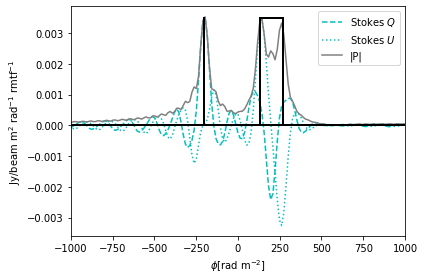

In [21]:
plt.plot(parameter.phi, F_dirty.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, F_dirty.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(F_dirty), '-', c='grey', label=r"|P|")
plt.plot([130., 130.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot([270., 270.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot([130., 270.], [0.0035, 0.0035], ls='-', lw=2., c='black')
plt.plot([-200., -200.], [0., 0.0035], ls='-', lw=2., c='black')
plt.plot(parameter.phi, np.zeros(len(parameter.phi)), ls='-', lw=2., c='black')
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.xlim([-1000, 1000])
plt.tight_layout()
plt.savefig("fds_sim3.png", dpi=100)

In [22]:
idx_noise = np.where(np.abs(parameter.phi) > 10000)
noise_F = np.std(0.5 * (F_dirty[idx_noise].real + F_dirty[idx_noise].imag))
noise_F

3.4104767e-05

In [23]:
F_back = nufft.backward(dataset.data)

(-1000.0, 1000.0)

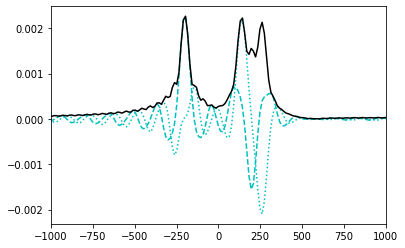

In [24]:
plt.plot(parameter.phi, F_back.real, 'c--', label=r"Real part")
plt.plot(parameter.phi, F_back.imag, 'c:', label=r"Imaginary part")
plt.plot(parameter.phi, np.abs(F_back), 'k-', label=r"Amplitude")
plt.xlim([-1000, 1000])

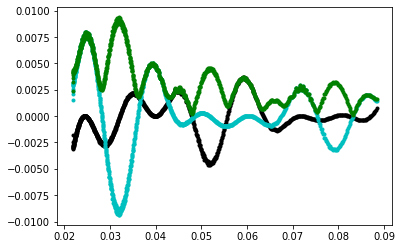

In [25]:
P_back = nufft.forward_normalized(F_back)
plt.plot(dataset.lambda2, P_back.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, P_back.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(P_back), 'g.', label=r"$|P|$")

In [26]:
lambda_l1 = np.sqrt(2.0 * dataset.m + 4.0 * np.sqrt(dataset.m)) * noise_F
#lambda_l1 /= 10
#lambda_l1=0.5
lambda_tsv = 0.0
chi2 = Chi2(dft_obj=nufft)
l1 = L1(reg=lambda_l1)
tsv = TSV(reg=lambda_tsv)
# F_func = [chi2(P, dft, W), L1(lambda_l1)]
F_func = [chi2, l1, tsv]
f_func = [chi2]
g_func = [l1, tsv]

F_obj = OFunction(F_func)
f_obj = OFunction(f_func)
g_obj = OFunction(g_func)

In [27]:
parameter.data = F_dirty

In [28]:
parameter.complex_data_to_real()

In [29]:
opt = FISTA(guess_param=parameter, F_obj=F_obj, fx=chi2, gx=g_obj, noise=noise_F, verbose=True)
#opt = FISTA(i_guess=F_real, F_obj=F_obj, fx=chi2, gx=g_obj, maxiter=1000, noise=1e-5, verbose=True)
obj, X = opt.run()

Iterations set to 46
Iteration:  0  objective function value: 0.00994


In [30]:
X.real_data_to_complex()

(-1000.0, 1000.0)

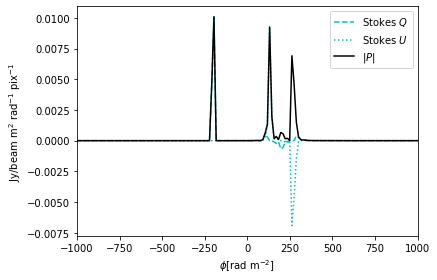

In [31]:
plt.plot(parameter.phi, X.data.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, X.data.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(X.data), 'k-', label=r"$|P|$")
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ pix$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.xlim([-1000, 1000])

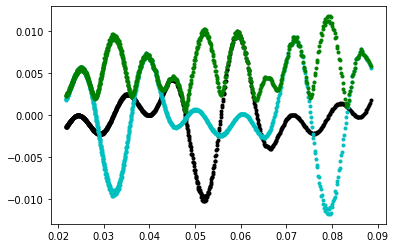

In [32]:
plt.plot(dataset.lambda2, dataset.model_data.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.model_data.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.model_data), 'g.', label=r"$|P|$")

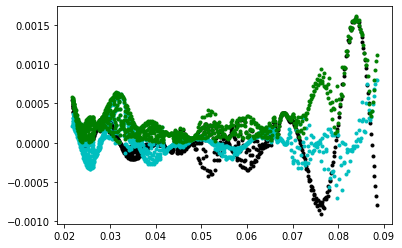

In [33]:
plt.plot(dataset.lambda2, dataset.residual.real, 'k.', label=r"Stokes $Q$")
plt.plot(dataset.lambda2, dataset.residual.imag, 'c.', label=r"Stokes $U$")
plt.plot(dataset.lambda2, np.abs(dataset.residual), 'g.', label=r"$|P|$")

In [34]:
F_residual = nufft.backward(dataset.residual)

In [35]:
conv_model = X.convolve() + F_residual

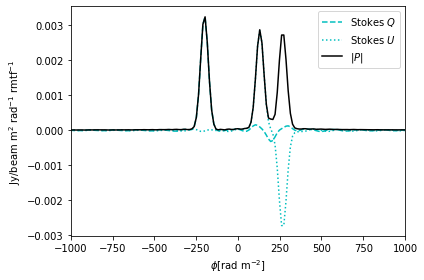

In [36]:
plt.plot(parameter.phi, conv_model.real, 'c--', label=r"Stokes $Q$")
plt.plot(parameter.phi, conv_model.imag, 'c:', label=r"Stokes $U$")
plt.plot(parameter.phi, np.abs(conv_model), 'k-', label=r"$|P|$")
plt.xlim([-1000, 1000])
plt.xlabel(r'$\phi$[rad m$^{-2}$]')
plt.ylabel(r'Jy/beam m$^2$ rad$^{-1}$ rmtf$^{-1}$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("restored.png", dpi=100)